# 한번에 모두 적기

In [7]:
# 1. Import Module
import os, sys
import random
#import itertools
#import io
#import math
import pandas as pd
import numpy as np
import numpy
#import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import cv2
import pandas as pd
import math
import time

from tqdm import tqdm

from torchvision import datasets, transforms
from transformers import GLPNForDepthEstimation, GLPNFeatureExtractor
from transformers import DetrFeatureExtractor, DetrForObjectDetection
from PIL import Image

################################################################################################################################
# 2. Data 및 변수 세팅
df = pd.read_csv('./annotations.csv')
train_image_list = os.listdir('./data/image/train') # 40570

# label을 COCO dataset과 동일하게 맞추기
df['class'].replace({'Cyclist':'bicycle','Car':'car','Van':'car','Tram':'train',
                     'Person_sitting':'person','Pedestrian':'person','Truck':'truck'}, inplace=True)
df.filename = [f.replace('txt', 'png') for f in df.filename] # .txt -> .png

# 내가 원하는 이미지
k = 1050
mask = df['filename'] == train_image_list[k]
df_choose = df.loc[mask]
#print(df_choose)

# Real data의 class와 좌표값 
class_list = df_choose[['class']].values
coordinates = df_choose[['xmin','ymin','xmax','ymax']].values

# 이미지 open
img = Image.open(os.path.join('./data/image/train/',train_image_list[k]))
img_shape = cv2.imread(os.path.join('./data/image/train/',train_image_list[k])).shape


################################################################################################################################
# 3. Model 불러오기
# 모델 불러오기
# COCO classes (91개)
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# Preprocessing and bounding box
# standard PyTorch mean-std input image normalization
dpt_transform = transforms.Compose([
    #transforms.Resize(800),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

# Detection
def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)
    #img_shape = img.shape

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

detr_101 = torch.hub.load('facebookresearch/detr:main', 'detr_resnet101', pretrained=True) # Use resnet 101
detr_101.eval()
feature_extractor = GLPNFeatureExtractor.from_pretrained("vinvino02/glpn-kitti") # glpn-nyu2
model = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-kitti")
model.eval()


# 4. Object Detection and Make depth map
start = time.time() # 시간 측정 시작

scores, boxes = detect(img, detr_101, dpt_transform) # Detection

with torch.no_grad(): # Depth map
    pixel_values = feature_extractor(img, return_tensors="pt").pixel_values
    outputs = model(pixel_values) 
    predicted_depth = outputs.predicted_depth
    
    # interpolate to original size
    prediction = torch.nn.functional.interpolate(
                        predicted_depth.unsqueeze(1),
                        size=img_shape[:2],
                        mode="bicubic",
                        align_corners=False,
                 )
    prediction = prediction.squeeze().cpu().numpy() # shape => (375, 1242)

################################################################################################################################
# 5. Algorithm (Make data)
'''
############## Depth를 이용할 것인데, 이용하면 부적합한 모형이 도출될 것 같다는 판단.
# GLPDepth는 value가 작을수록 가까이 있다.
depth_min = []
depth_mean = []
input_coordinates = []
label = []
sub_min = []
correct_index = []

# 실제 데이터
for (real_xmin, real_ymin, real_xmax, real_ymax) in coordinates.tolist():
    real_xmin = int(real_xmin)
    real_ymin = int(real_ymin)
    real_xmax = int(real_xmax)
    real_ymax = int(real_ymax)
    dep_min = prediction[real_ymin:real_ymax+1, real_xmin:real_xmax+1].min()
    sub_min.append(dep_min) # real data의 bounding box에 대한 depth min값 저장
sub_min = np.array(sub_min)
print(sub_min) 

# DETR
index = 0 # Predict 값
for (xmin, ymin, xmax, ymax) in boxes:
    xmin0 = int(xmin)
    ymin0 = int(ymin)
    xmax0 = int(xmax)
    ymax0 = int(ymax)
    dep_min = prediction[ymin0:ymax0+1, xmin0:xmax0+1].min()
    dep_mean = prediction[ymin0:ymax0+1, xmin0:xmax0+1].mean()
    
    depth_min.append(dep_min) # DETR로 예측한 bounding box의 depth min값 저장
    #print(dep_min)
    depth_mean.append(dep_mean)
    
    correct_depth = np.where(sub_min == dep_min) # dep_max와 동일한 value   
    
    # 정확한 depth가 없을 때
    if len(correct_depth[0]) == 0:
        correct_depth = np.where((dep_min - 0.02 <= sub_min) & (sub_min <= dep_min)) # threshold value (유효범위 지정)
        if len(correct_depth[0])==0:
            continue
        elif len(correct_depth[0]) > 1:
            continue
        else:
            print(correct_depth[0])
            label.append(CLASSES[scores[index].argmax()]) # 같은 CLASSES로 분류했는지도 확인
            input_coordinates.append([xmin.detach(), ymin.detach(), xmax.detach(), ymax.detach()]) # 데이터와 동일한 곳의 이미지 좌표를 담기 (단, DETR로 예측한 값임)
    else:
        print(correct_depth[0])
        label.append(CLASSES[scores[index].argmax()])
        input_coordinates.append([xmin.detach(), ymin.detach(), xmax.detach(), ymax.detach()]) 
        
    correct_index.append(correct_depth[0][0])
    index += 1

input_coordinates = np.array(input_coordinates)
print(label)
print(input_coordinates)
#print(type(input_coordinates))
print(correct_index)
'''

# 좌표값의 제곱합(SSE)
input_coordinates = []
label = []

count = boxes.shape[0]
for (real_xmin, real_ymin, real_xmax, real_ymax) in coordinates.tolist():
    real_coord_array = np.repeat(np.array((real_xmin, real_ymin, real_xmax, real_ymax)).reshape(1,4), count, axis=0)
    
    result = np.sum(np.square(boxes.detach().numpy() - real_coord_array), axis=1) # 각각의 좌표를 빼서 가장 작은 값 찾기
    index = result.argmin()
    
    input_coordinates.append(boxes[index].detach().numpy())
    label.append(CLASSES[scores[index].argmax()])

input_coordinates = np.array(input_coordinates)
#print(input_coordinates)
#print(label)

end = time.time() # 시간 측정 끝
print(f"{end - start:.5f} sec") # 평균 6.4 sec'


################################################################################################################################
# 6. Make new data
glp_df = pd.DataFrame({'filename':df_choose['filename'], 'class':label, 'real_class':df_choose['class'], 
                       'xmin':input_coordinates[:,0], 'ymin':input_coordinates[:,1], 'xmax':input_coordinates[:,2], 
                       'ymax':input_coordinates[:,3], 'angle':df_choose['observation angle'], 'zloc':df_choose['zloc']})

#print(glp_df)
# 형식에 맞게 class 조절
for category in glp_df['class']:
    if category not in ['person', 'truck', 'car', 'bicycle', 'Misc', 'train']:
        glp_df['class'].replace({category:'Misc'}, inplace=True) # Misc class 설정
        
# 중복 데이터 제거
glp_df.drop_duplicates(['xmin','ymin','xmax','ymax'], inplace=True) # keep=False

glp_df = glp_df.loc[glp_df['class']==glp_df['real_class']] # class가 다르면 제외하기
glp_df.reset_index(inplace=True)
glp_df.drop('index',inplace=True,axis=1)
glp_df

Using cache found in C:\Users\Admin/.cache\torch\hub\facebookresearch_detr_main


12.30405 sec


,filename,class,real_class,xmin,ymin,xmax,ymax,angle,zloc
0,001050.png,person,person,218.933960,157.019684,247.092239,208.631943,-2.92,27.82
1,001050.png,car,car,206.385910,156.917679,270.036652,204.250107,1.30,31.16
2,001050.png,car,car,254.454132,162.894058,329.018250,200.411621,-1.97,33.71
3,001050.png,car,car,322.404510,164.129227,402.998962,197.040421,-2.02,35.28
4,001050.png,car,car,518.701355,158.463470,594.964722,188.732300,0.93,40.85
5,001050.png,car,car,588.480347,161.472809,639.411621,187.708313,-2.45,45.87
6,001050.png,car,car,643.625854,166.515945,674.038879,188.367020,-2.44,50.44
7,001050.png,car,car,687.197144,166.341827,760.889160,187.710403,-2.46,52.22
8,001050.png,car,car,753.720459,160.095932,792.675110,184.377670,0.48,57.76
9,001050.png,car,car,777.642456,163.461594,818.355042,183.379562,0.46,59.45


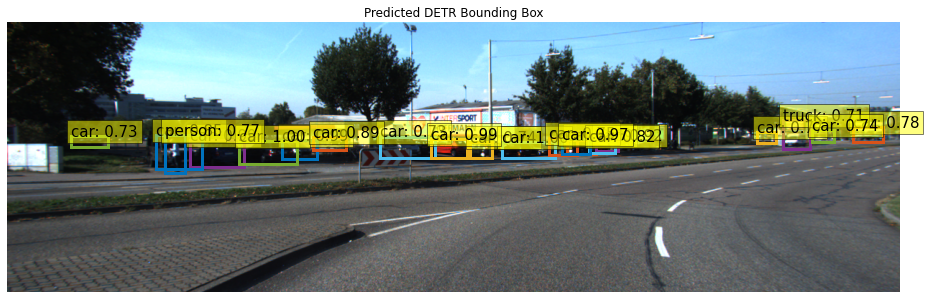

In [8]:
# 기존의 DETR 예측
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.title('Predicted DETR Bounding Box')
    plt.show()
    
plot_results(img, scores, boxes)

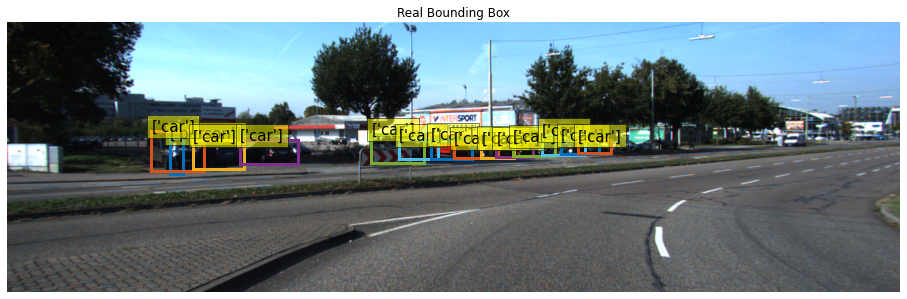

In [9]:
# 기존의 Real Data
def plot_results0(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        #cl = p.argmax()
        text = p
        ax.text(xmin, ymin, p, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.title('Real Bounding Box')
    plt.show()

plot_results0(img, class_list, coordinates)

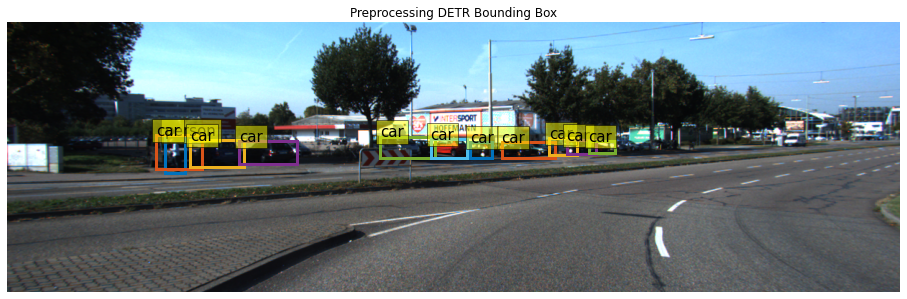

In [10]:
# Preprocessing DETR Result
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p
        text = p
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.title('Preprocessing DETR Bounding Box')
    plt.show()
    
plot_results(img, glp_df['class'], glp_df[['xmin','ymin','xmax','ymax']].values)

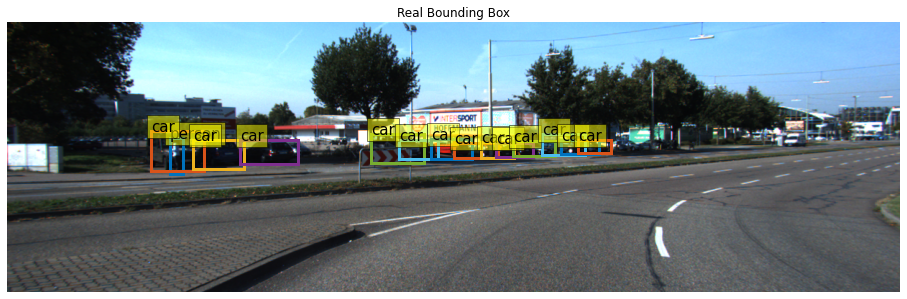

In [11]:
# Real Result
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p
        text = p
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.title('Real Bounding Box')
    plt.show()
    
plot_results(img, df_choose['class'], df_choose[['xmin','ymin','xmax','ymax']].values)